In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import tight_binding as tb

import data_analysis as da
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
plotroot="hallplots/equal-time-from-nersc/density/"
resultroot="halldata/equal-time-from-nersc/density/"

In [5]:
Nx = "8"; Ny = "8"; nt = "1.0"; tp='0'; N = int(Nx) * int(Ny)
nflux_list = np.load(resultroot+f"Nx{Nx}_Ny{Ny}_tp{tp}_nflux.npy")
Us_list = np.load(resultroot+f"Nx{Nx}_Ny{Ny}_tp{tp}_Us.npy")
betas_list = np.load(resultroot+f"Nx{Nx}_Ny{Ny}_tp{tp}_betas.npy")
nf_arr = np.array(list(map(float,nflux_list)));
B_arr = nf_arr/N; 
nF = len(nflux_list);nT = len(betas_list);nU = len(Us_list)
tt_prefix = f"{Nx}x{Ny} t'={tp}"

In [6]:
mu_arr = np.linspace(-6,6,101);nmu = mu_arr.shape[0];

In [7]:
print("nflux_list:",nflux_list,"length =",nF)
print("betas_list:",betas_list,"length =",nT);
print("Us_list:",Us_list,"length =",nU); 

nflux_list: ['0' '1' '2' '3' '4' '6' '8' '12' '16' '20' '24' '28' '32'] length = 13
betas_list: ['3' '4' '5' '6'] length = 4
Us_list: ['0' '2' '4' '6' '8'] length = 5


In [8]:
mu_ld = np.load(resultroot+f"Nx{Nx}_Ny{Ny}_tp{tp}_mu.npy")
density_ld = np.load(resultroot+f"Nx{Nx}_Ny{Ny}_tp{tp}_density.npy")
densityerr_ld = np.load(resultroot+f"Nx{Nx}_Ny{Ny}_tp{tp}_densityerr.npy")
num_ok = np.count_nonzero(~np.isnan(density_ld))
print(f"{int(num_ok)}/{density_ld.size} = {int(num_ok)/density_ld.size:.3g} of data is saved in directory {resultroot}")
print(f"density_ld.shape = {density_ld.shape}")

26260/26260 = 1 of data is saved in directory halldata/equal-time-from-nersc/density/
density_ld.shape = (4, 5, 13, 101)


# Filling, DOS, Compressibility

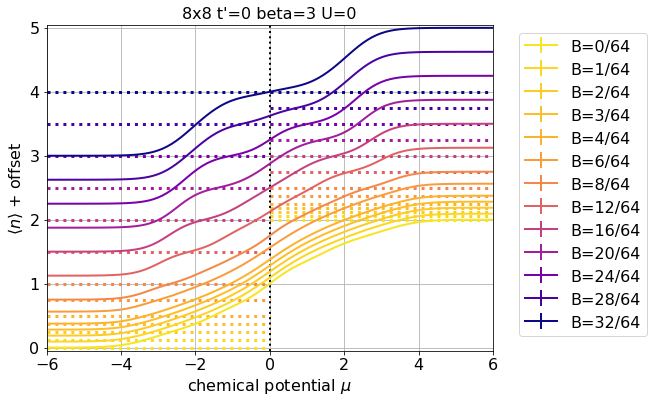

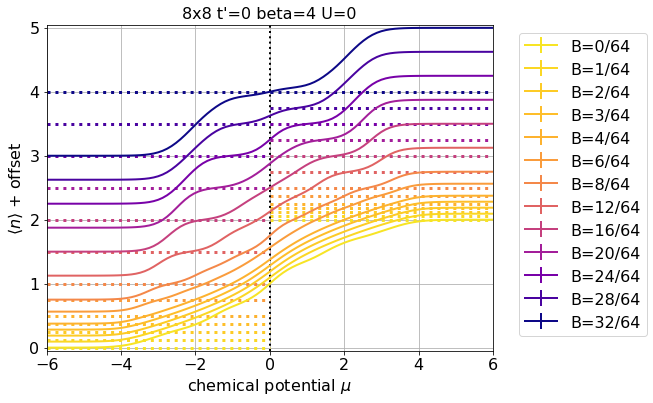

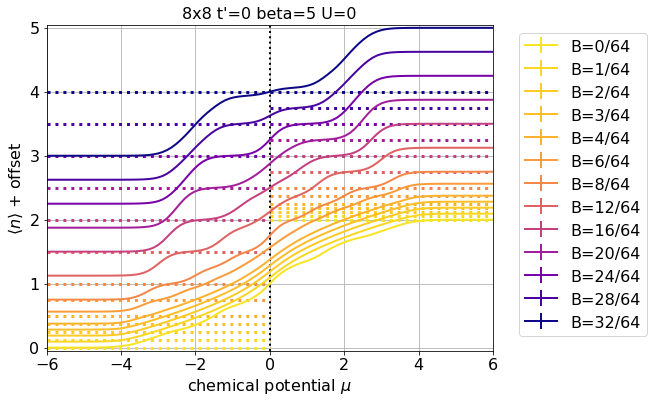

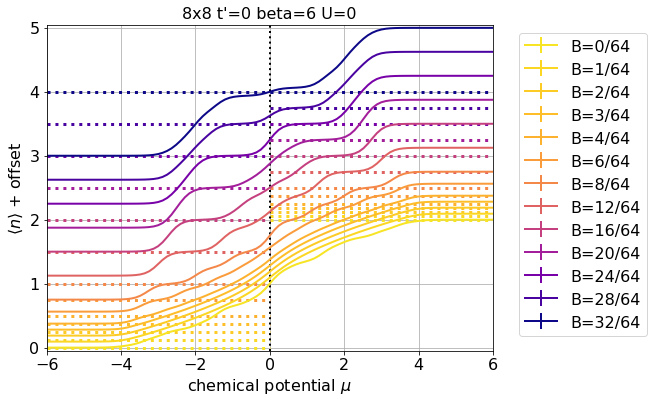

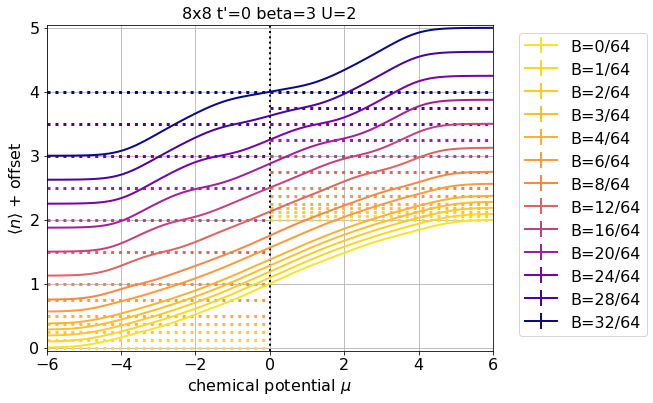

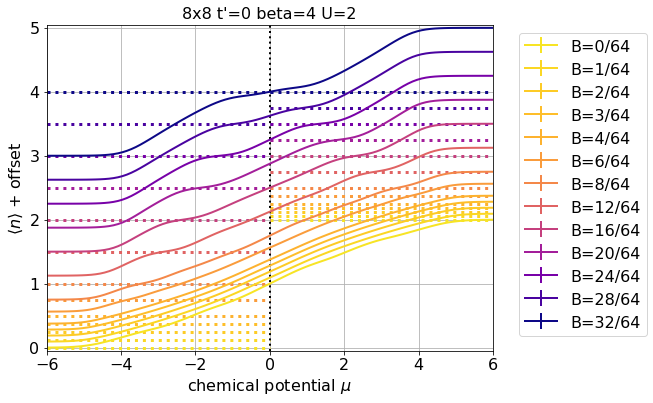

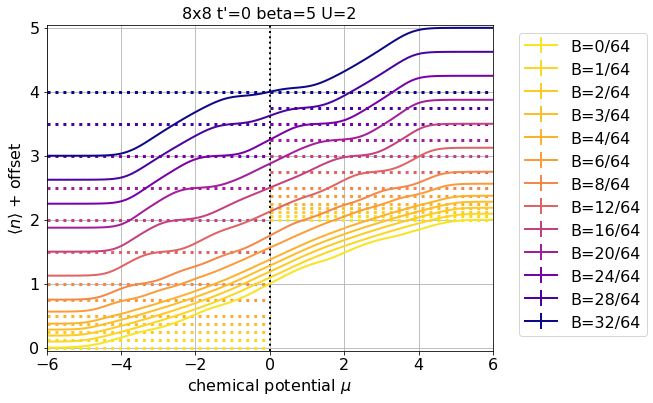

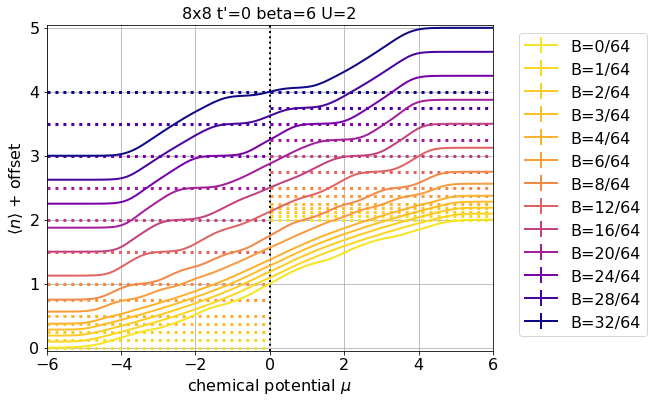

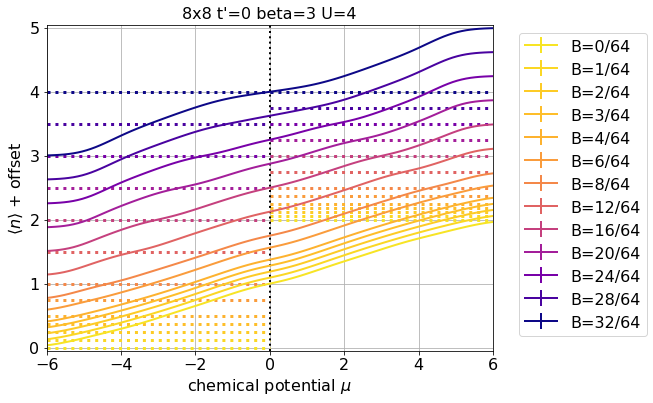

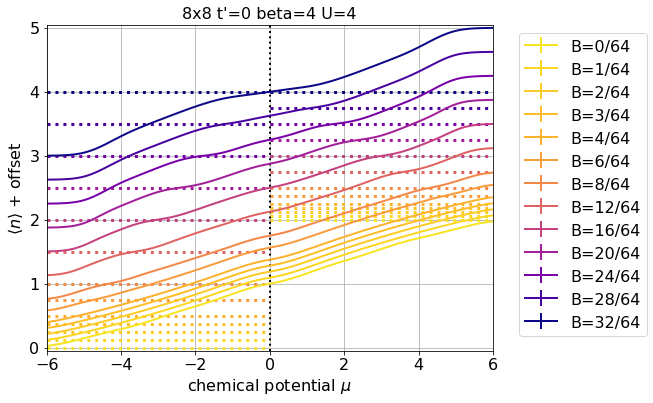

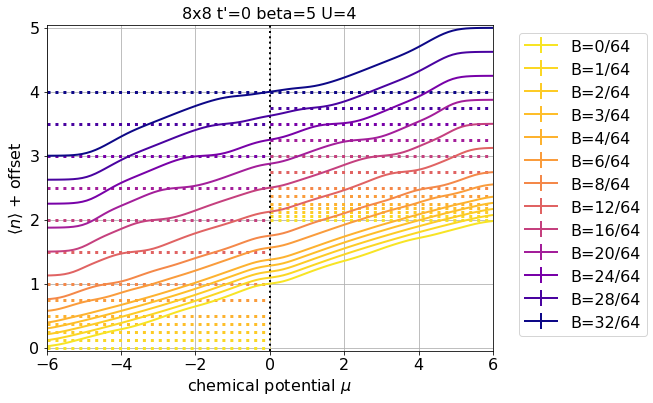

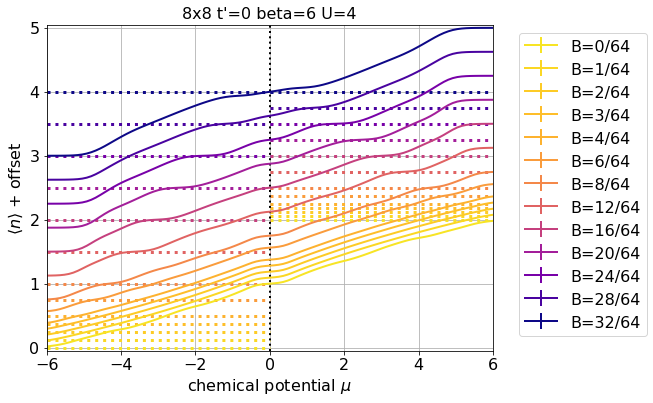

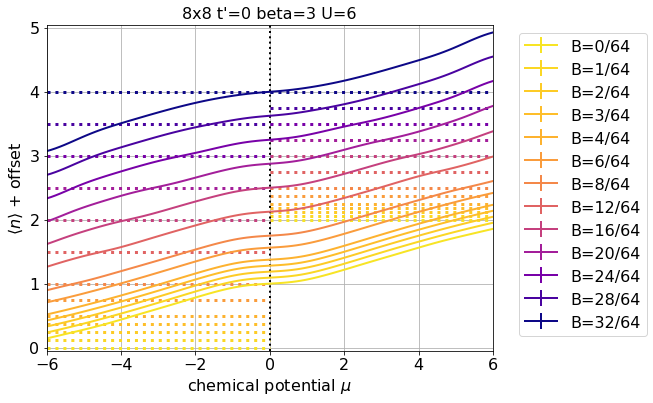

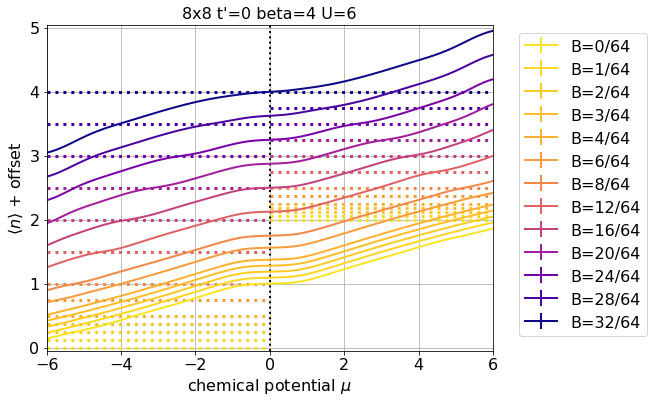

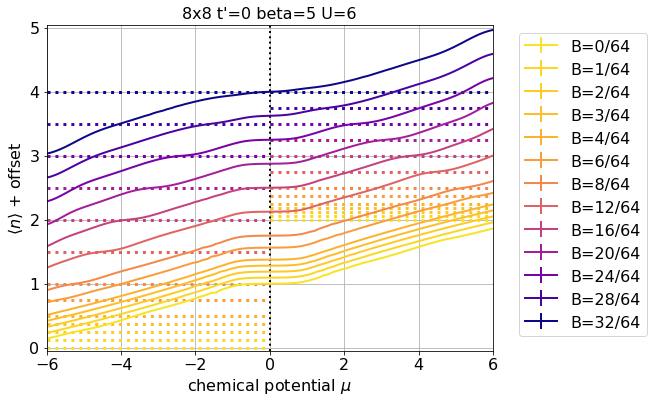

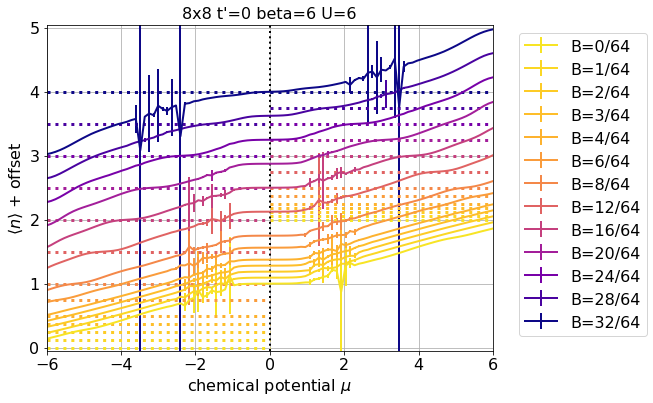

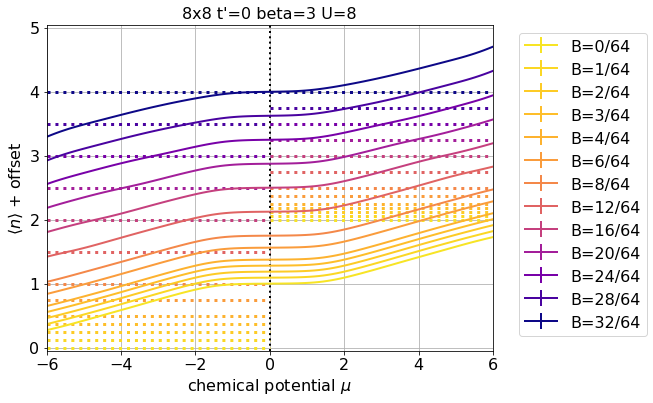

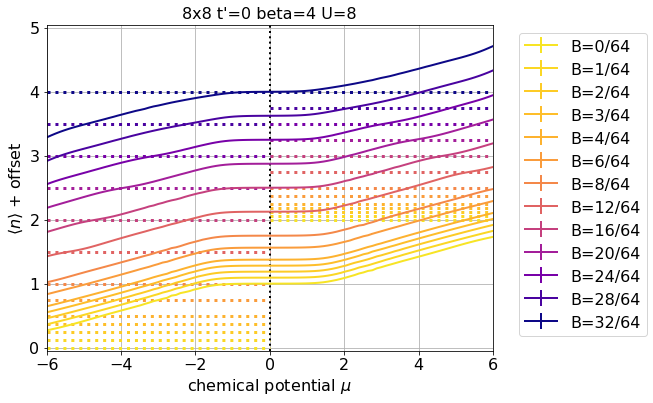

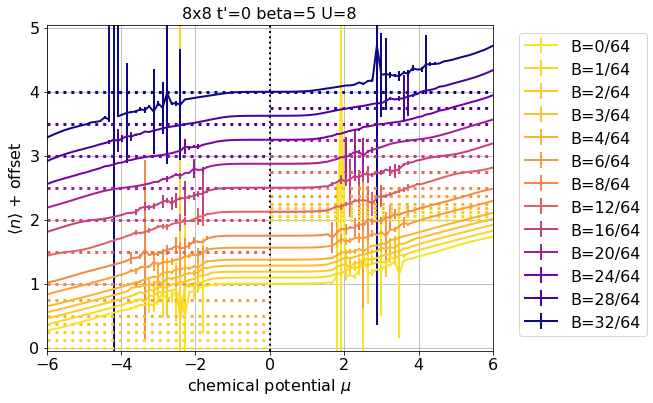

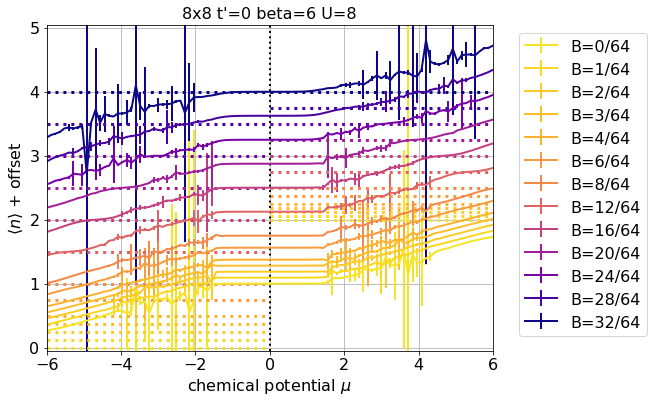

In [9]:
colors = plt.cm.plasma(0.95*(1-nf_arr/nf_arr.max()))
for j in range(nU):
    Us = Us_list[j]
    for i in range(nT):
        betas=betas_list[i]
        plt.figure(figsize=(8,6));
        plt.title(tt_prefix + f" beta={betas} U={Us}")
        offset = nf_arr/nf_arr.max()*3 
        n=0
        for k in range(nF):
            nflux = nflux_list[k]
            #spl = InterpolatedUnivariateSpline(mu_ld,density_ld[i,j,k,:].real,ext='raise',check_finite=True)
            #d = spl.derivative();
            plt.errorbar(mu_ld,density_ld[i,j,k,:].real+offset[k],\
                         yerr = densityerr_ld[i,j,k,:],label=f"B={nflux_list[k]}/{N}",lw=2,\
                         color=colors[k])
            plt.axhline(y=offset[k] + 2*B_arr[k],xmax=0.5,ls=":",lw=3,color=colors[k])
            plt.axhline(y=offset[k] + 2-2*B_arr[k],xmin=0.5,ls=":",lw=3,color=colors[k])
            n+=1
        plt.xlabel(r"chemical potential $\mu$")
        plt.ylabel(r"$\langle n \rangle $ + offset")
        plt.xlim(-6,6)
        plt.ylim(-0.05,5.05)
        plt.grid(True)
        plt.axvline(x=0,color='k',lw=2,ls=":")
        #plt.axhline(y=1.0,color='k',lw=1)
        #plt.xlabel(r"B [$\Phi_0/a^2$]")
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        #plt.savefig(f'{plotroot}{Nx}x{Ny}_tp{tp}_beta{betas}_U{Us}_n_vs_mu.png',dpi=300,bbox_inches="tight")
        plt.show()

In [14]:
def eps_k(Nx,Ny):
    Nx = int(Nx); Ny = int(Ny)
    nxarr = np.reshape(np.arange(Nx),(Nx,1));
    nyarr = np.arange(Ny);
    return -2*(np.cos(2*np.pi/Nx * nxarr) + np.cos(2*np.pi/Ny * nyarr) )

In [15]:
def Beps_k(Ny, Nx, ty=1.0, tx=1.0, tp=0.0, typp=0.0, txpp=0.0, nflux=0):
    B = nflux/(Ny*Nx)
    tij = np.zeros((Ny*Nx, Ny*Nx), dtype=np.complex)
    for iy in range(Ny):
        for ix in range(Nx):
            iy1 = (iy + 1) % Ny
            ix1 = (ix + 1) % Nx
                #jx    jy    ix    iy
            tij[ix + Nx*iy1, ix + Nx*iy] += ty * np.exp(1j*np.pi*B*( 1* ix + (0 if iy1 > iy else  Ny* ix)))
            tij[ix + Nx*iy, ix + Nx*iy1] += ty * np.exp(1j*np.pi*B*(-1* ix + (0 if iy1 > iy else -Ny* ix)))
            tij[ix1 + Nx*iy, ix + Nx*iy] += tx * np.exp(1j*np.pi*B*( 1*-iy + (0 if ix1 > ix else  Nx*-iy)))
            tij[ix + Nx*iy, ix1 + Nx*iy] += tx * np.exp(1j*np.pi*B*(-1*-iy + (0 if ix1 > ix else -Nx*-iy)))

            tij[ix1 + Nx*iy1, ix + Nx*iy] += tp * np.exp(1j*np.pi*B*( 1*ix  +  1*-iy  + (0 if iy1 > iy else  Ny*ix1) + (0 if ix1 > ix else  Nx*-iy1) + (-Nx*Ny if ix1 < ix and iy1 < iy else 0)))
            tij[ix + Nx*iy, ix1 + Nx*iy1] += tp * np.exp(1j*np.pi*B*(-1*ix1 + -1*-iy1 + (0 if iy1 > iy else -Ny*ix ) + (0 if ix1 > ix else -Nx*-iy ) + ( Nx*Ny if ix1 < ix and iy1 < iy else 0)))
            tij[ix1 + Nx*iy, ix + Nx*iy1] += tp * np.exp(1j*np.pi*B*(-1*ix  +  1*-iy1 + (0 if iy1 > iy else -Ny*ix1) + (0 if ix1 > ix else  Nx*-iy ) + ( Nx*Ny if ix1 < ix and iy1 < iy else 0)))
            tij[ix + Nx*iy1, ix1 + Nx*iy] += tp * np.exp(1j*np.pi*B*( 1*ix1 + -1*-iy  + (0 if iy1 > iy else  Ny*ix ) + (0 if ix1 > ix else -Nx*-iy1) + (-Nx*Ny if ix1 < ix and iy1 < iy else 0)))

            iy2 = (iy + 2) % Ny
            ix2 = (ix + 2) % Nx
            tij[ix + Nx*iy2, ix + Nx*iy] += typp * np.exp(1j*np.pi*B*( 2* ix + (0 if iy2 > iy else  Ny* ix)))
            tij[ix + Nx*iy, ix + Nx*iy2] += typp * np.exp(1j*np.pi*B*(-2* ix + (0 if iy2 > iy else -Ny* ix)))
            tij[ix2 + Nx*iy, ix + Nx*iy] += txpp * np.exp(1j*np.pi*B*( 2*-iy + (0 if ix2 > ix else  Nx*-iy)))
            tij[ix + Nx*iy, ix2 + Nx*iy] += txpp * np.exp(1j*np.pi*B*(-2*-iy + (0 if ix2 > ix else -Nx*-iy)))
    #print(np.max(np.abs(tij - np.conj(tij.T))))
    return -np.linalg.eigh(tij)[0]

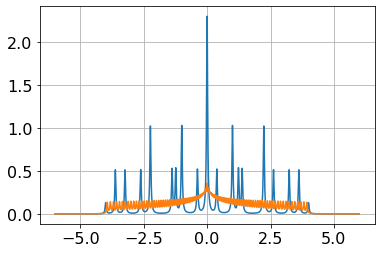

In [16]:
Earr = np.linspace(-6,6,8001);
eps_k_mat = eps_k(Nx,Ny);
dos = np.zeros(Earr.shape,dtype=float)
for i in range(int(Nx)):
    for j in range(int(Ny)):
        dos += tb.poisson(1/40,Earr,eps_k_mat[i,j])/N
plt.figure()
plt.plot(Earr,dos)
plt.grid(True)

Bek = Beps_k(int(Nx), int(Ny), tp=0, nflux=1) 
Bek = np.reshape(Bek,(int(Nx),int(Ny)))
Bdos = np.zeros(Earr.shape,dtype=float)
for i in range(int(Nx)):
    for j in range(int(Ny)):
        Bdos += tb.poisson(1/40,Earr,Bek[i,j])/N
plt.plot(Earr,Bdos)


## dn/dmu from DQMC

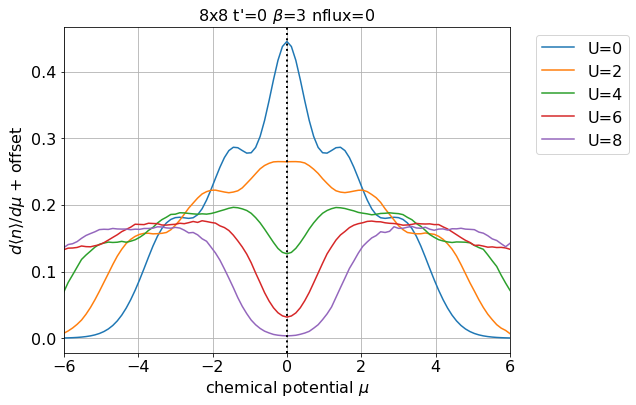

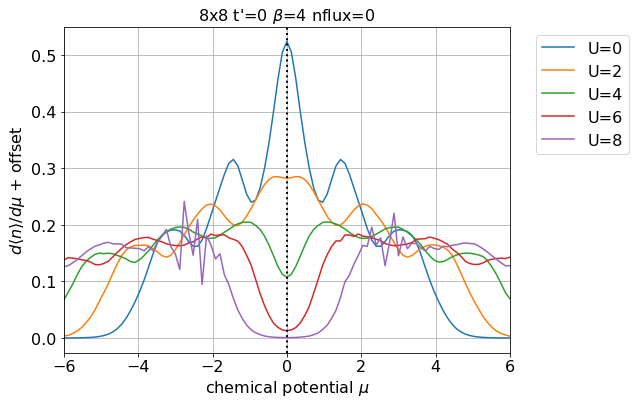

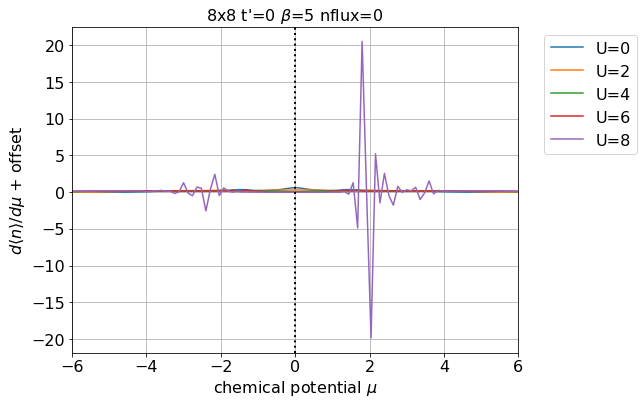

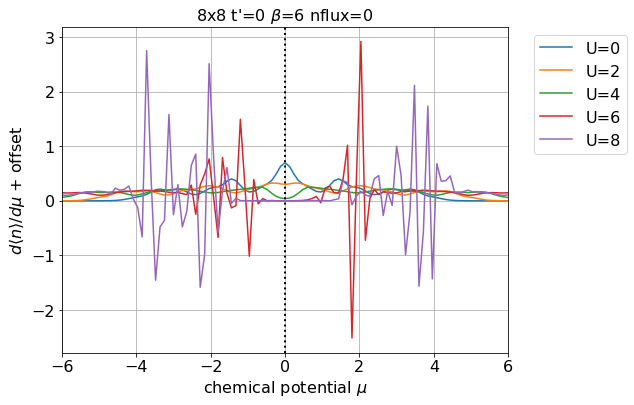

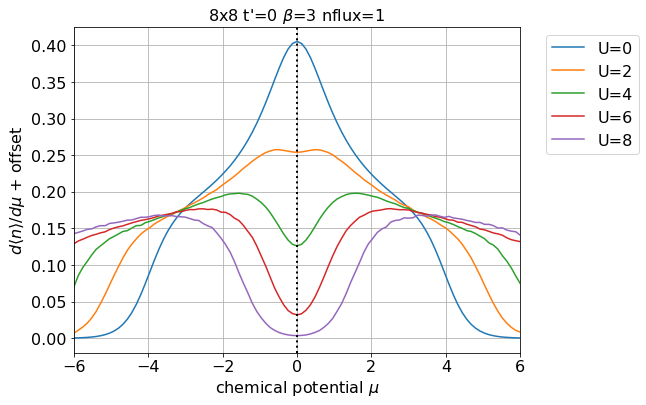

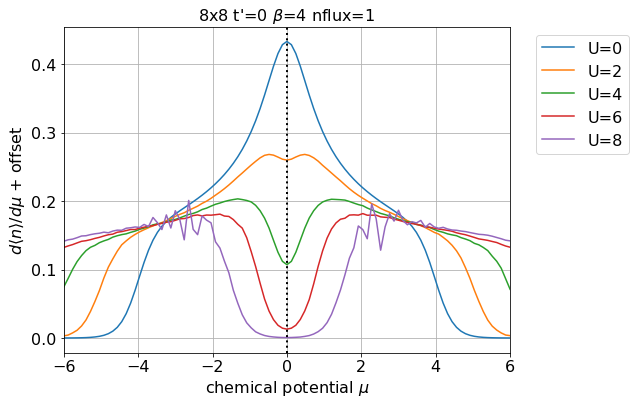

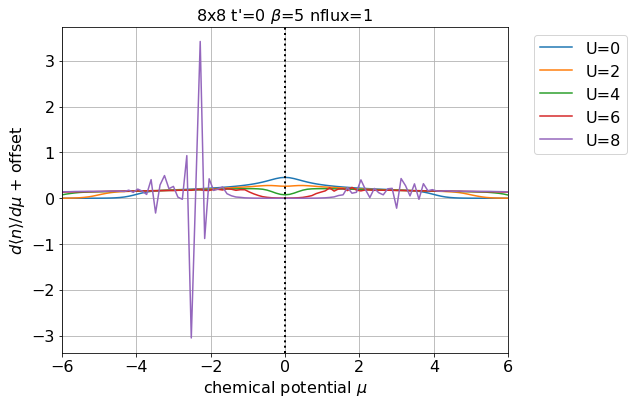

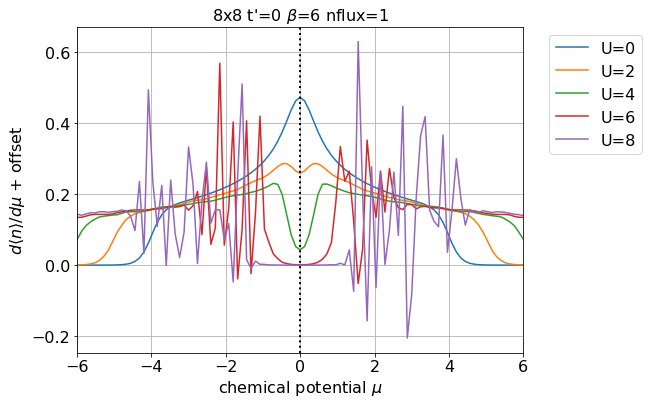

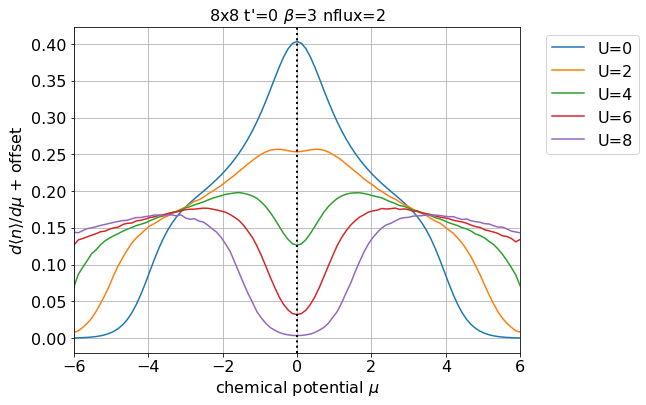

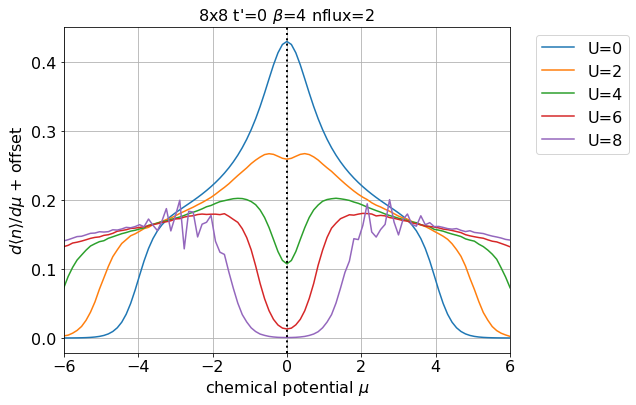

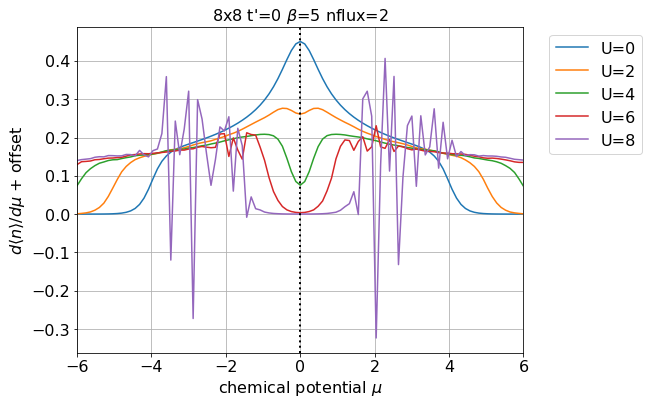

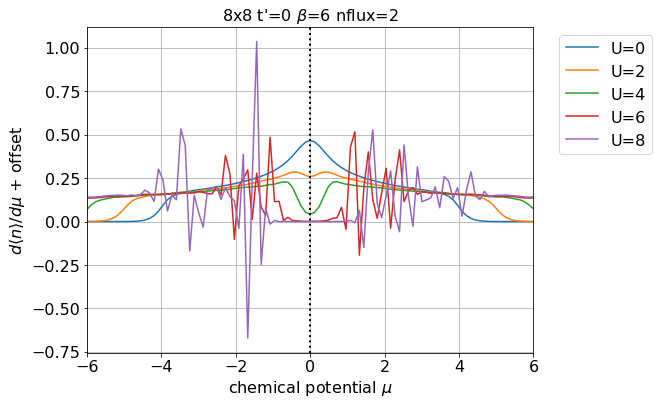

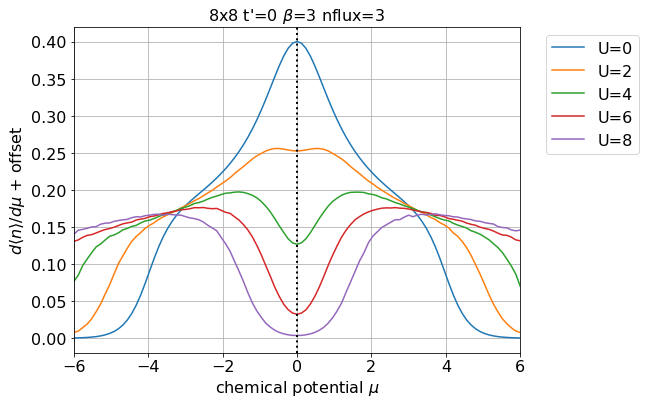

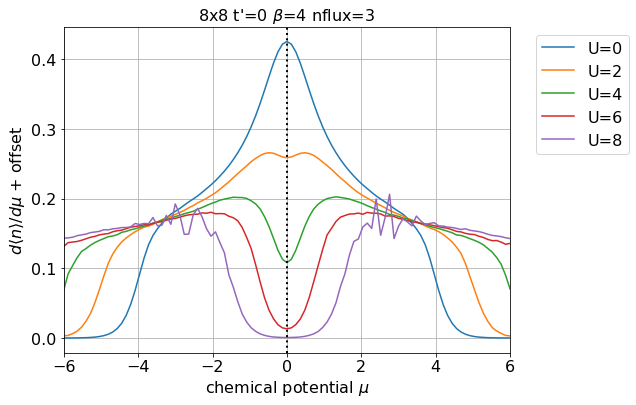

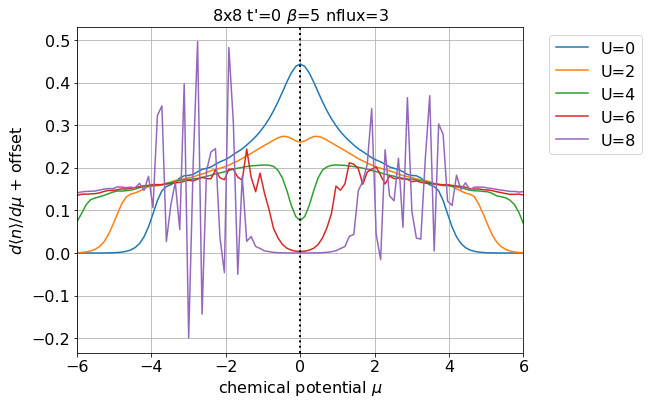

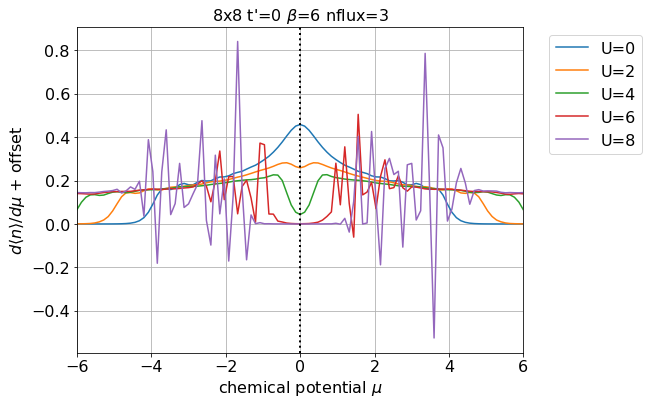

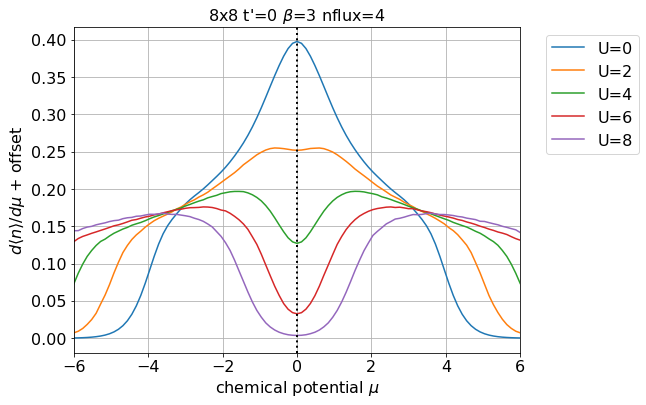

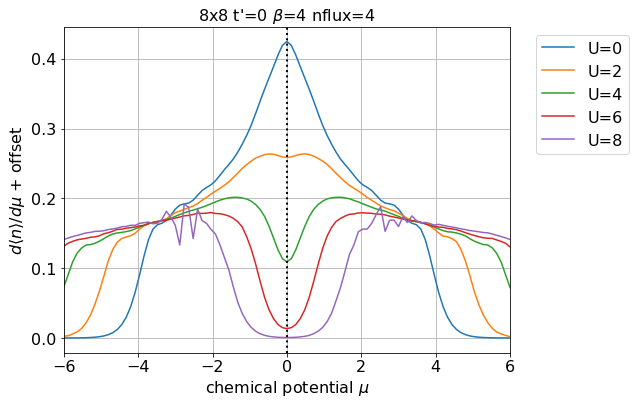

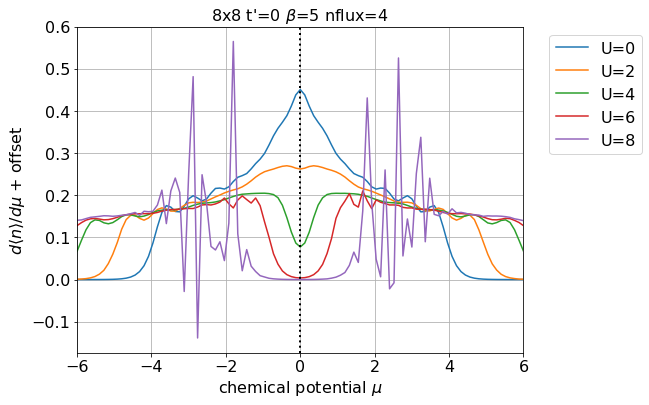

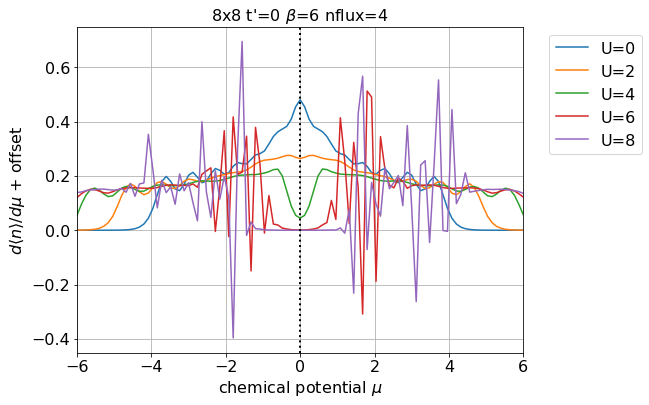

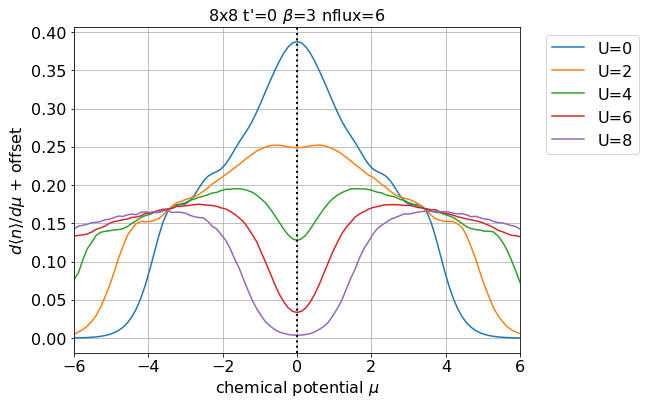

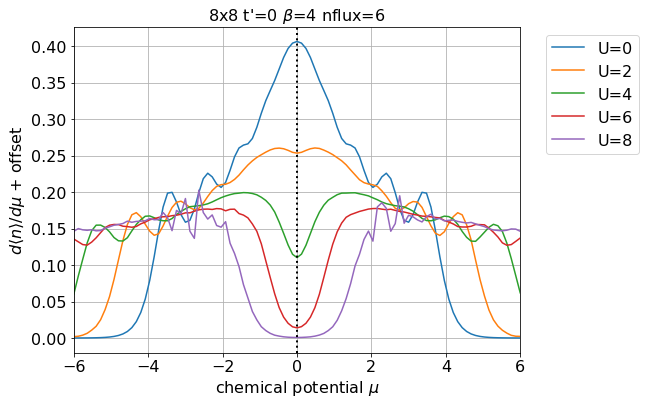

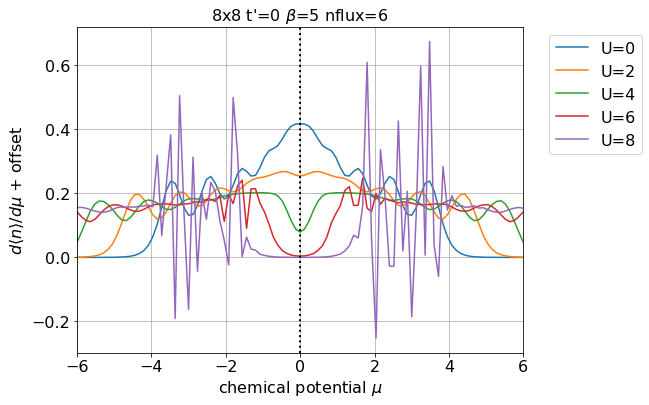

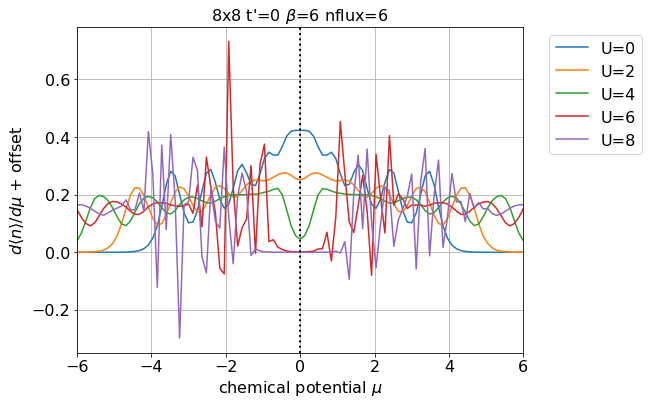

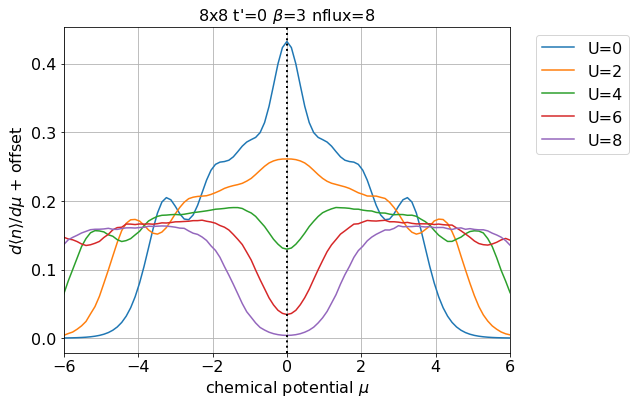

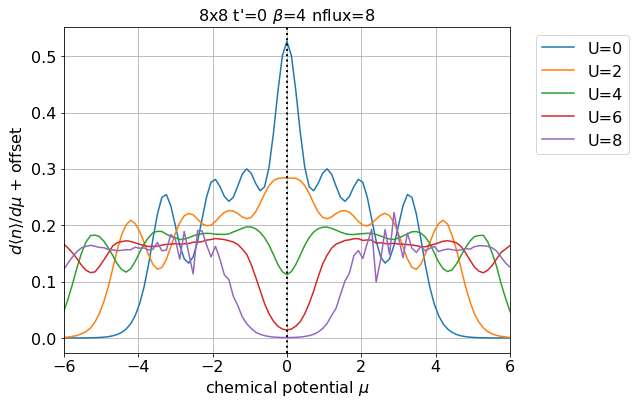

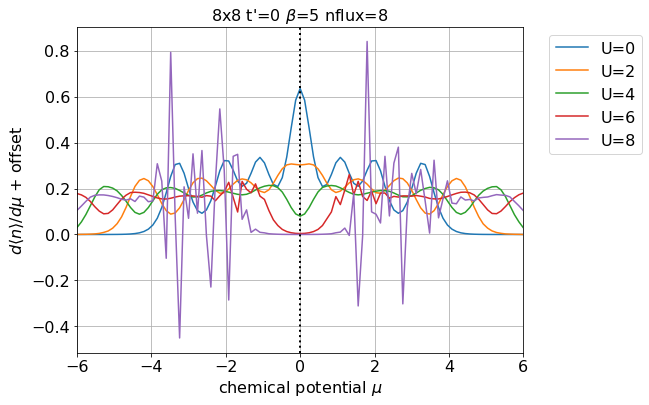

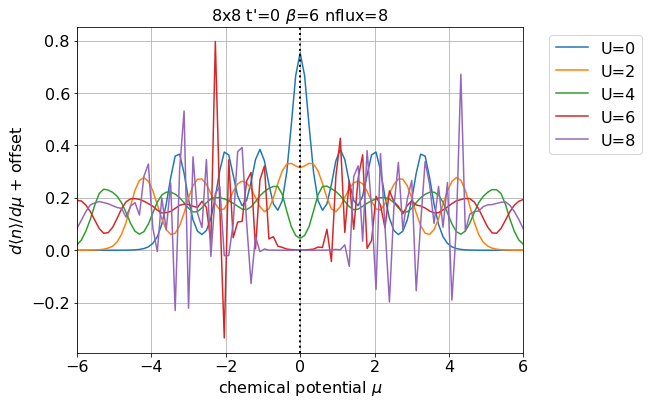

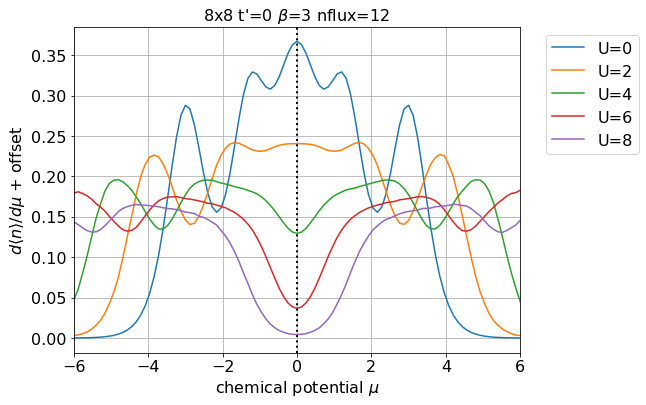

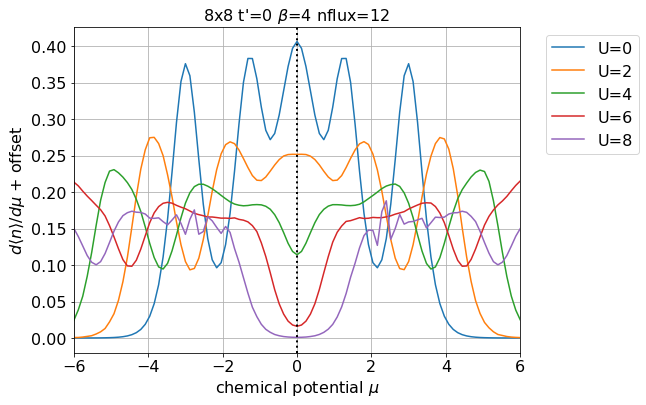

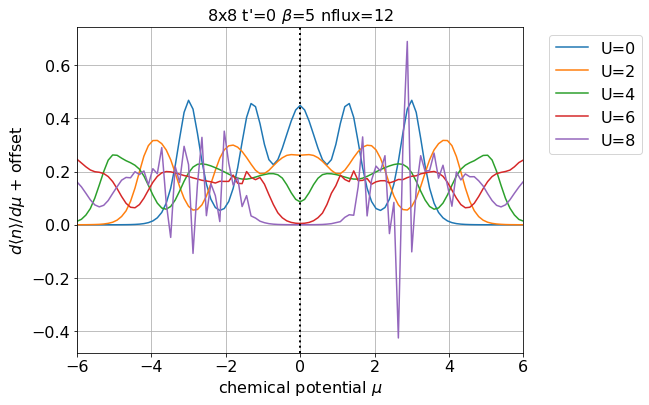

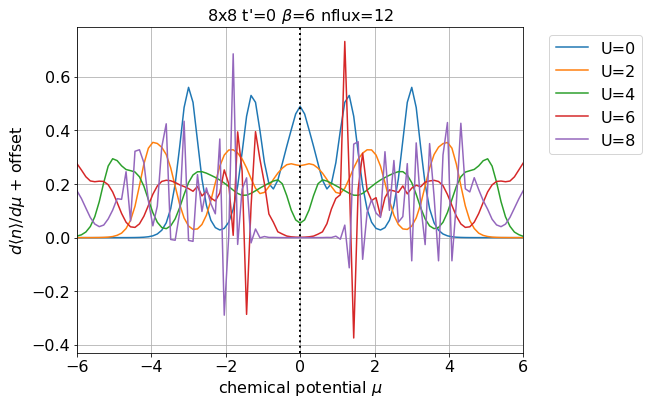

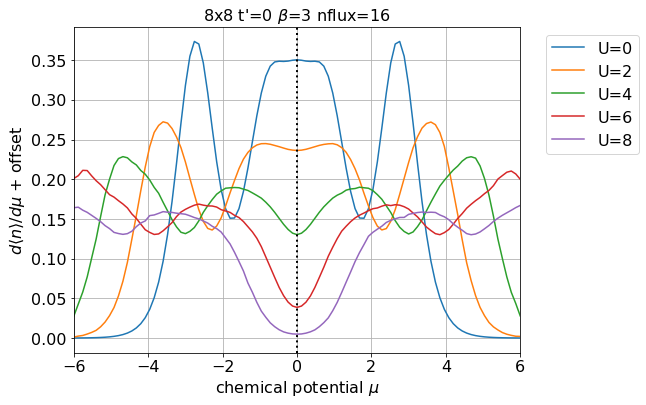

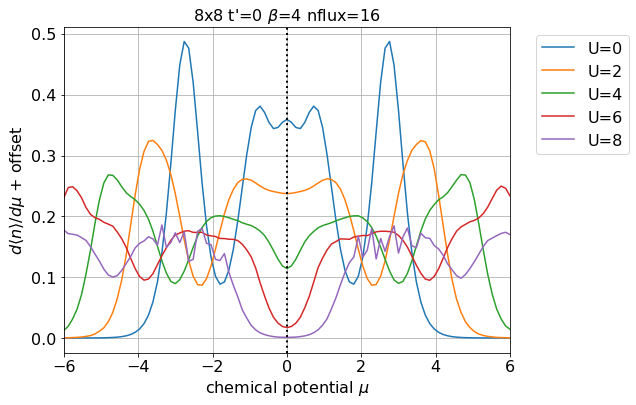

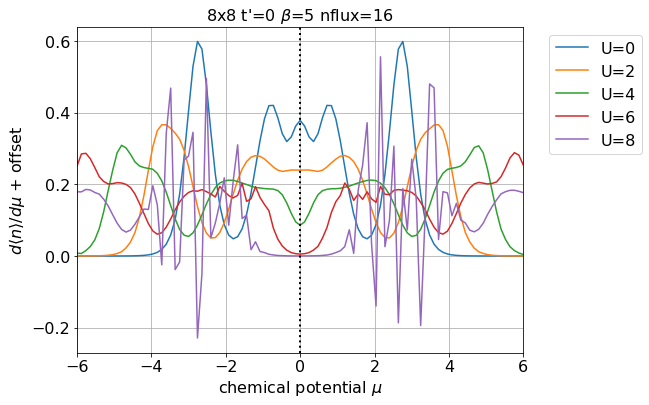

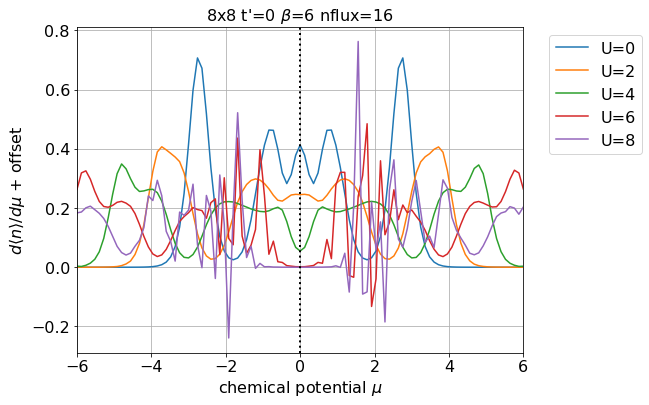

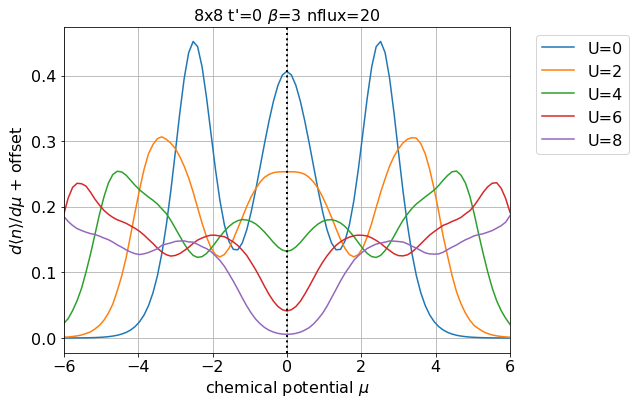

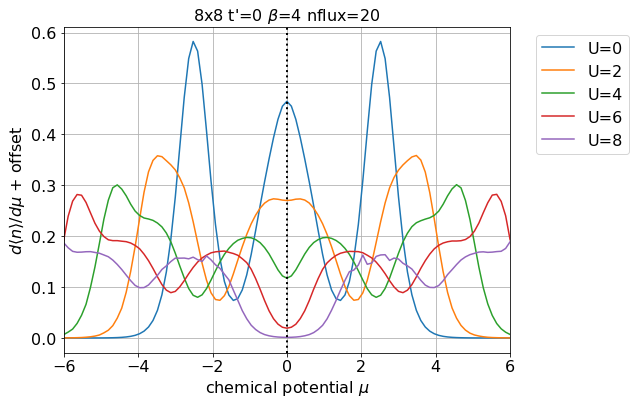

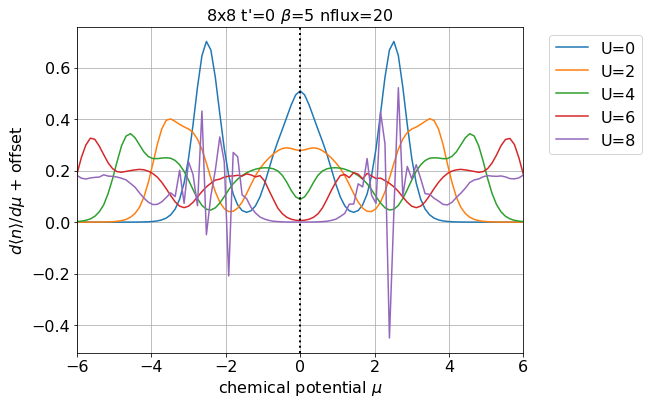

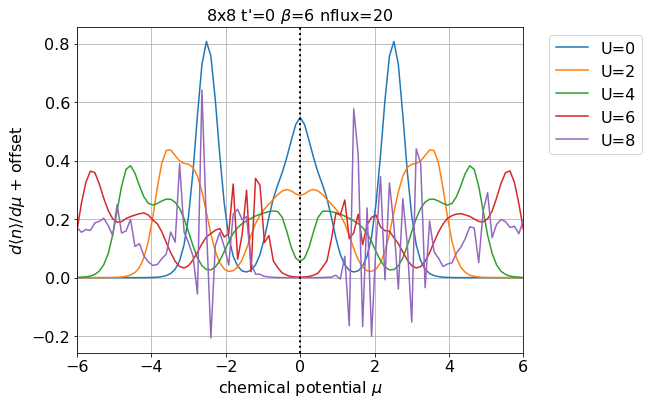

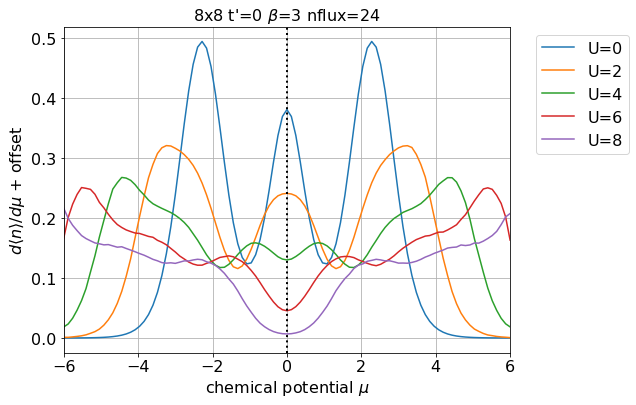

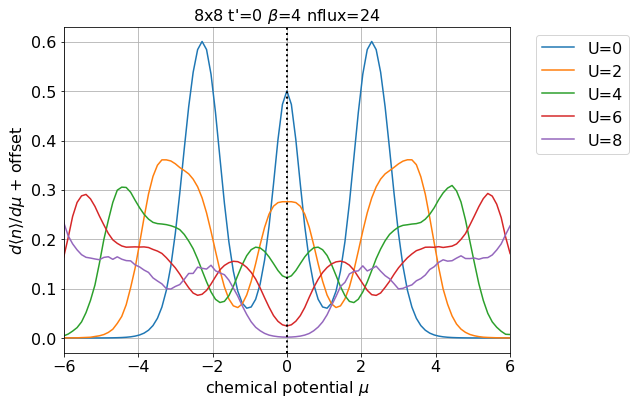

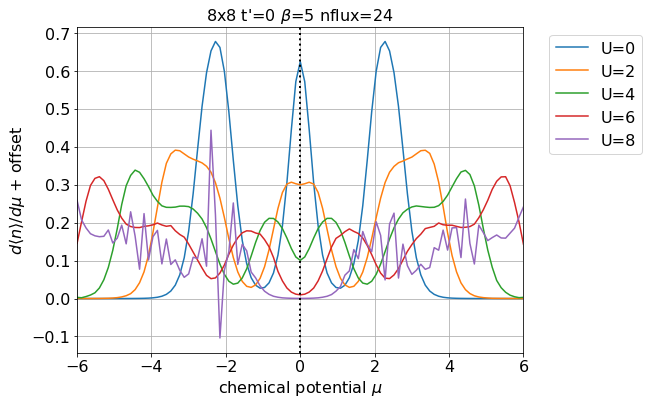

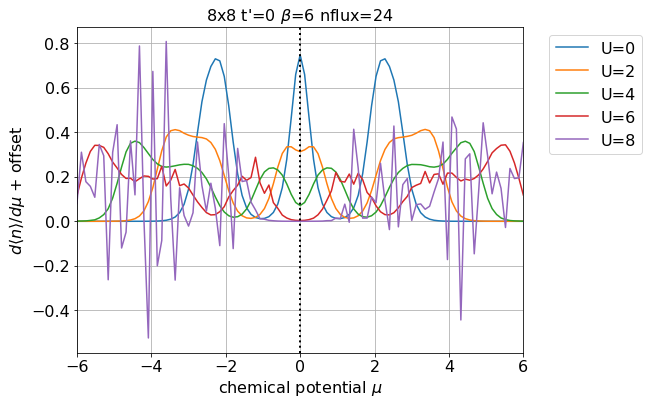

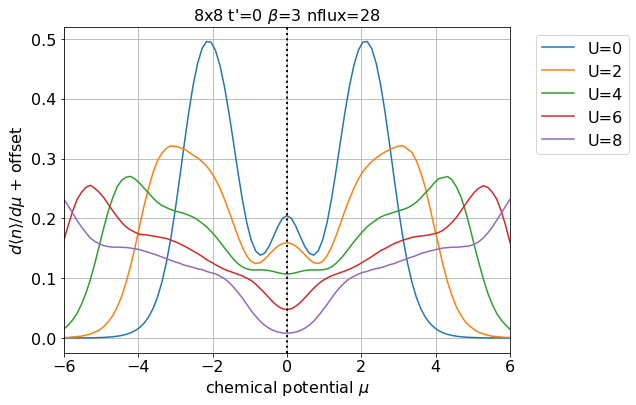

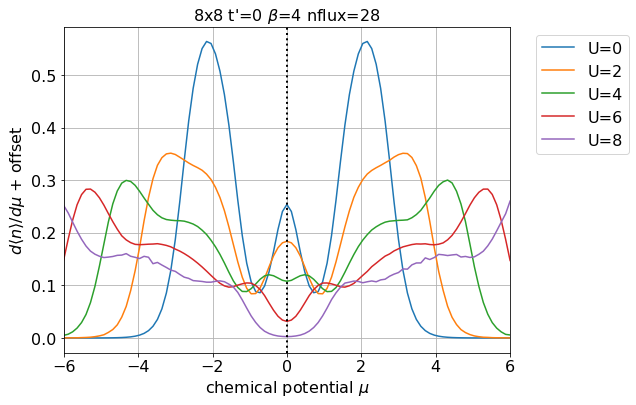

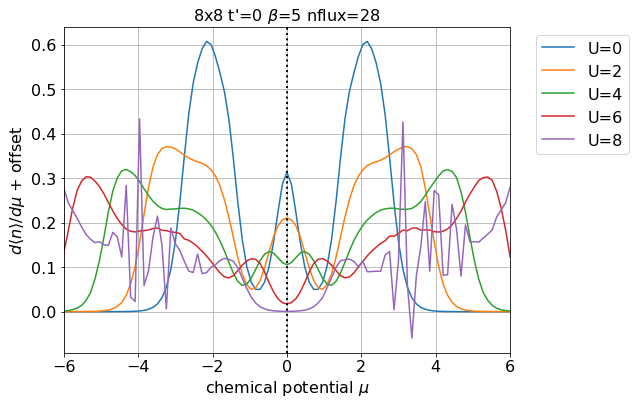

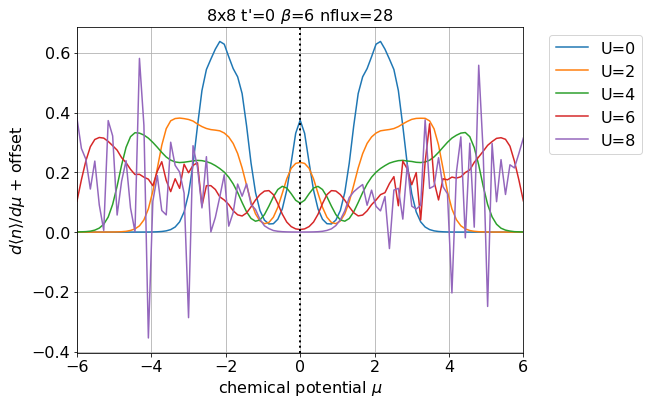

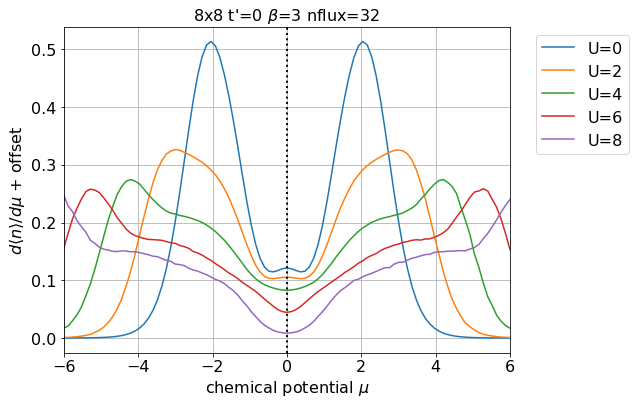

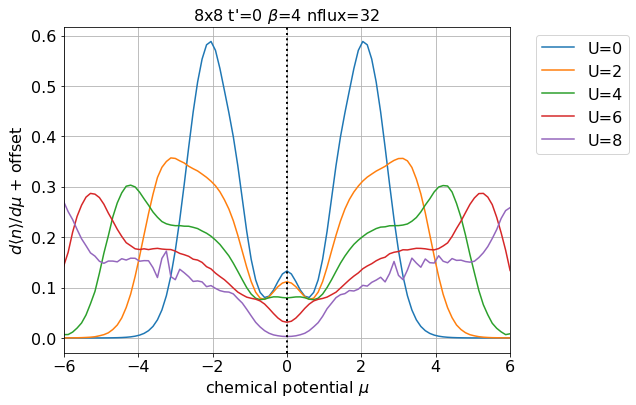

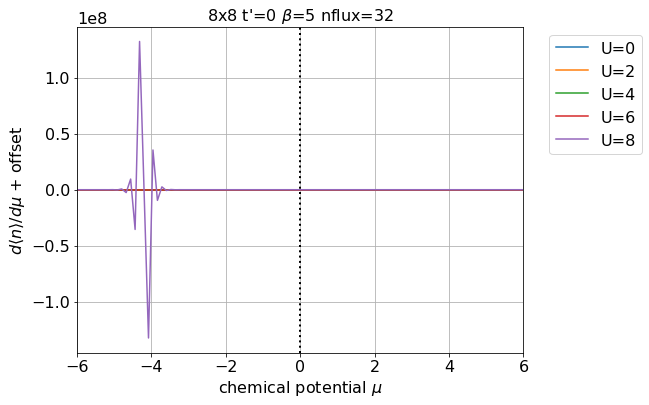

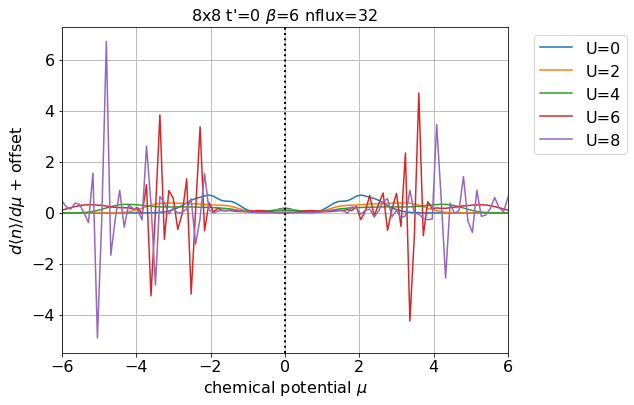

In [23]:
colors = plt.cm.plasma(0.95*(1-nf_arr/nf_arr.max()))
for k in range(nF):
    nflux = nflux_list[k]
    for i in range(nT):
        betas=betas_list[i]
        plt.figure(figsize=(8,6));
        plt.title(tt_prefix + fr" $\beta$={betas} nflux={nflux}")
        offset = nf_arr/nf_arr.max()*4
        n=0
        for j in range(nU):
            Us = Us_list[j]
            if np.all(np.isfinite(density_ld[i,j,k,:])):
                spl = InterpolatedUnivariateSpline(mu_ld,density_ld[i,j,k,:].real,ext='raise',check_finite=True)
                d = spl.derivative();
                plt.plot(mu_ld,d(mu_ld),label=f"U={Us}")
            n+=1
        plt.xlabel(r"chemical potential $\mu$")
        plt.ylabel(r"$d\langle n \rangle/d\mu $ + offset")
        plt.xlim(-6,6)
        plt.grid(True)
        plt.axvline(x=0,color='k',lw=2,ls=":")
        #plt.xlabel(r"B [$\Phi_0/a^2$]")
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        #plt.savefig(f'{plotroot}{Nx}x{Ny}_tp{tp}_beta{betas}_nflux{nflux}_dndmu.png',dpi=300,bbox_inches="tight")
        plt.show()

## dn/dmu exact noninteracting

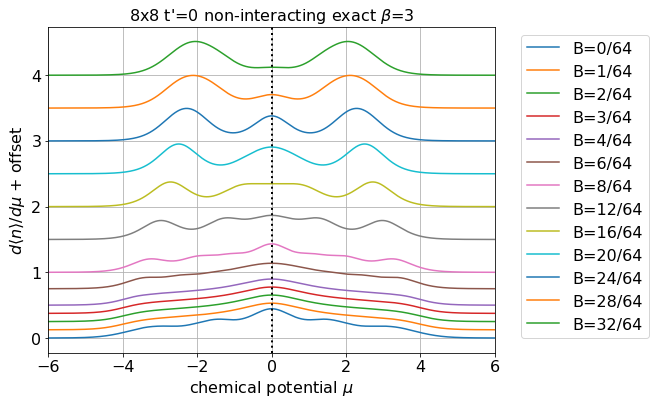

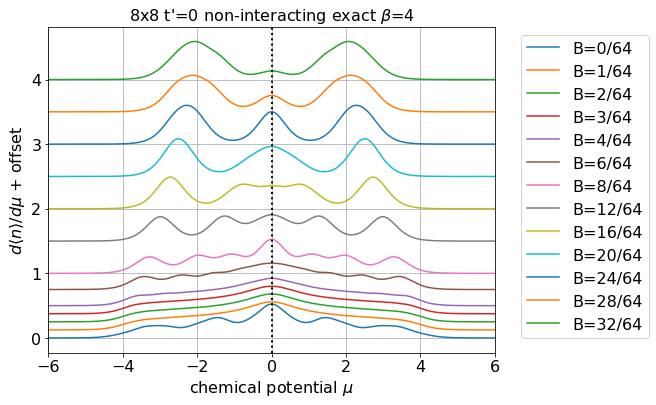

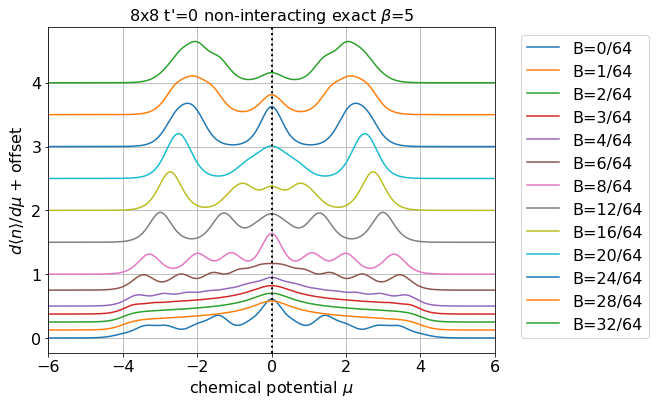

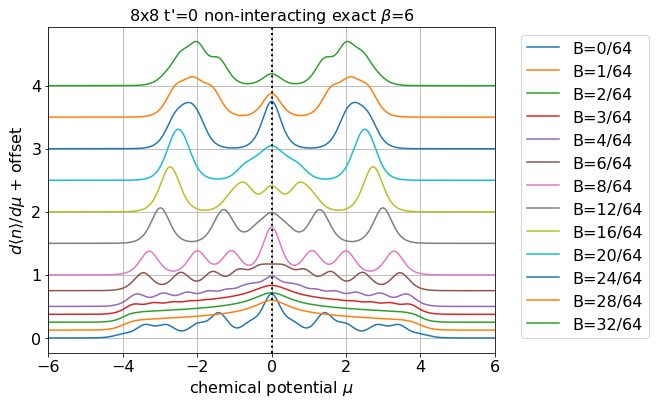

In [24]:
colors = plt.cm.plasma(0.95*(1-nf_arr/nf_arr.max()))
n=0
for i in range(nT):
    betas=betas_list[i]
    plt.figure(figsize=(8,6));
    plt.title(tt_prefix + fr" non-interacting exact $\beta$={betas}")
    offset = nf_arr/nf_arr.max()*4
    for k in range(nF):
        nflux = nflux_list[k]
        Bek = Beps_k(int(Nx), int(Ny), tp=0, nflux=nf_arr[k]) 
        dndmu = np.sum(tb.f_dist_deriv_mat(Bek,Earr,float(betas)),axis=0)/N*2
        plt.plot(Earr,dndmu + offset[k],label=f"B={nflux_list[k]}/{N}")
    #plt.yticks([])
    plt.xlabel(r"chemical potential $\mu$")
    plt.ylabel(r"$d\langle n\rangle /d\mu$ + offset")
    plt.xlim(-6,6)
    plt.grid(True)
    plt.axvline(x=0,color='k',lw=2,ls=":")
    #plt.xlabel(r"B [$\Phi_0/a^2$]")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.savefig(f'{plotroot}{Nx}x{Ny}_tp{tp}_beta{betas}_nonint_dndmu.png',dpi=300,bbox_inches="tight")
    plt.show()

# Sign

NameError: name 'sign_ld' is not defined

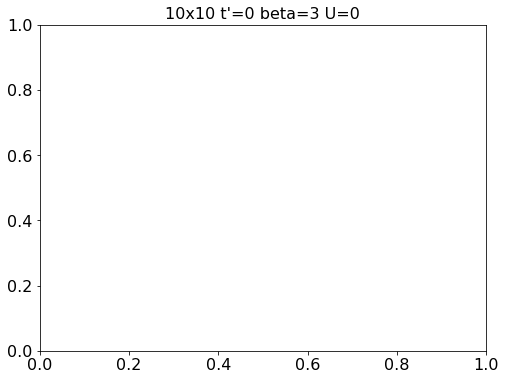

In [16]:
colors = plt.cm.plasma(0.95*(1-nf_arr/nf_arr.max()))
for j in range(nU):
    Us = Us_list[j]
    for i in range(nT):
        betas=betas_list[i]
        plt.figure(figsize=(8,6));
        plt.title(tt_prefix + f" beta={betas} U={Us}")
        n = 0
        for k in range(nF):
            nflux = nflux_list[k]
            plt.errorbar(density_ld[i,j,k,:].real,sign_ld[i,j,k,:].real,\
                         xerr = densityerr_ld[i,j,k,:], yerr = signerr_ld[i,j,k,:],\
                         label=f"B={B_arr[k]:.3g}",lw=3, color=colors[k])
            plt.axvline(x=B_arr[k]*2,color=colors[k],ls=":",lw=3)
            plt.axvline(x=2-B_arr[k]*2,color=colors[k],ls=":",lw=3)
            #plt.yscale("log")
            n+=1
        plt.xlabel(r"$\langle n \rangle$")
        plt.ylabel(r"$\langle s \rangle$")
        plt.grid(True)
        plt.xlim(0,2)
        plt.yscale('log')
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.axvline(x=1,color='k',lw=2,ls="--")
        plt.savefig(f'{plotroot}{Nx}x{Ny}_tp{tp}_beta{betas}_U{Us}_sign.png',dpi=300,bbox_inches="tight")
        plt.show()